# **HOUSE ROCKET INSIGHTS PROJECT**

## 1. **House Rocket, Business Problem and Solution Plan**

House Rocket is a real estate company whose business model consists in identifying good deals, so that those properties could be bought for an interesting price and futurely sold for a higher price, so that the company could turn in a profit. For this particular case, House Rocket will be operating in King County, which includes Seattle.

*Obs: The  company and business problem are both fictitious, although the data is real.*

**Problem 1: Which properties should House Rocket buy and for which suggested price?**

To solve this problem, we firstly need to analyse the properties by their location, because in real estate, location is undoubtedly a decisive factor in price evaluation. One interesting metric in this case is to calculate the price median by each zipcode, as the median isn't influenced by extreme values (outliers) in the data. 

The properties that will receive a buy suggestion will be the ones that fulfill the two following rules:

- Their asked price has to be lower than the median price for that region
- The property needs to be in good conditions, which means condition >= 3

As for the suggested price, the density by region will be taken into account, which means that for properties in regions that have a higher number of real estate ads it's viable to offer lower prices, and vice-versa. Therefore the rule for suggested buy prices is:

- From 0 to 204 properties in the region => Offer the asked price 
- From 205 to 282 properties in the region => Offer 3% less than the asked price
- From 283 to 408 properties in the region => Offer 4% less than the asked price
- From 409 properties upwards => Offer 5% less than the asked price

**Problem 2: Once a property is bought, for which price should it be sold?**

To suggest a sell price, again the density by region will be considered, since for regions where the number of real estate ads is lower it's possible to sell the property for a higher price, and vice-versa. Hence, a reasonable rule for suggested sell prices is:

- From 0 to 204 properties in the region => Sell for 16% than the suggested buy price 
- From 205 to 282 properties in the region => Sell for 14% than the suggested buy price
- From 283 to 408 properties in the region => Sell for 12% than the suggested buy price
- From 409 properties upwards => Sell for 10% than the suggested buy price

*It's important to point out that selling a property for 10-16% more than the paid price is just a suggestion, so that the selling prices are realistic, since selling a property on a short run for say 30-40% more, although it can happen, it seems unlikely (or it would take too long to sell).*

## 2. **Importing Libraries, Creating Functions and Loading Data**

### 2.1. Importing Libraries

In [5]:
# Lbraries
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
import geopandas
import folium
from streamlit_folium import folium_static
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### 2.2. Creating functions

In [6]:
# Functions
def outlier_identifier(df, col, a=10, b=5, c=5, asc=False):  
    """ 
    This function returns a boxplot for the selected DataFrame
    column in order to help detecting outliers. 
    The sorted values for the select column is also returned.      
    """   
    boxplot = df[[col]].boxplot(figsize=(a,b)); # Boxplot
    sorted_values = df.sort_values(col,ascending=asc).head(c) # Sorted Values
    return sorted_values

def get_data(path, convert=True):
    """ 
    This function returns the loaded data.
    The price column is renamed to "asked_price", 
    because we will be working with several price definitions,
    such as suggested_buy_price, suggested_sell_price, etc.    
    The 'date' column is converted to datetime64[ns] by default.    
    """   
    if convert==True:
        data = pd.read_csv(path).rename({'price':'asked_price'},axis=1) # Reading data and renaming the column
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') # Converting to datetime
    else:
        data = pd.read_csv(path).rename({'price':'asked_price'},axis=1)
    return data

def get_geofile(url):
    """ 
    This function returns the loaded geofile data.    
    """     
    geofile = geopandas.read_file(url)
    return geofile

def zipcode_map(data, geofile, col, data_):
    """ 
    This function returns a density map (considering the zipcode) based on the selected column.    
    """     
    geofile = geofile[geofile['ZIP'].isin(data['ZIP'].tolist())] # Get the geofile data for the zipcodes present in the data
    data = geofile.loc[geofile['COUNTY']=='033'].sort_values('ZIP') # Only gets the county code = 33
    data[col] = data_[col].values.round(decimals=2)        

    zipcode_mapa = folium.Map(location=[47.63050, -122.24000], default_zoom_start=25) 

    folium.Choropleth(data = data,
                    geo_data = geofile,
                    columns=['ZIP', col], # What will show in the map
                    key_on='feature.properties.ZIP',
                    fill_color='YlOrRd', 
                    fill_opacity = 0.7,
                    line_opacity = 0.2,
                    legend_name=col,
                    overlay=True,
                    show=True).add_to(zipcode_mapa)

    style_function = lambda x: {'fillColor': '#ffffff', 
                                'color':'#000000', 
                                'fillOpacity': 0.1, 
                                'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    
    gjson = folium.features.GeoJson(data = data, 
                                style_function=style_function, 
                                control=False,
                                highlight_function=highlight_function, 
                                tooltip=folium.features.GeoJsonTooltip(
                                fields=['ZIP',col],
                                aliases=['ZIP',col],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))
    zipcode_mapa.add_child(gjson) # gjson adds a hover feature 
    zipcode_mapa.keep_in_front(gjson)
    return zipcode_mapa

def suggestion_map(data_mapa, hover_col):
    """ 
    This function returns a map on which the buy suggestion and suggested buy price for each property is shown.
    """     
    map_ = px.scatter_mapbox(data_mapa, 
                             lat='lat', 
                             lon='long',
                             size='asked_price', # Size based on the asked price 
                             hover_name='id',
                             hover_data=hover_col, 
                             color='buy_suggestion', # Color based on whether the buy suggestion is 'Yes' or 'No'
                             color_continuous_scale='rdgy', 
                             zoom=8, 
                             height=300)

    map_.update_layout(mapbox_style = 'open-street-map')
    map_.update_layout(height=600, margin= {'r': 0, 't': 0, 'l':  0, 'b': 0} )
    map_.show()
    return None

def avg_profit_func(df_sell, col, group_by_col):
    """ 
    This function returns DataFrame with both profit mean and median,
    grouped by the selected columns.    
    """     
    avg_profit_by_ = df_sell[col].groupby(group_by_col).mean().reset_index().rename({'profit':'avg_profit'},axis=1)
    median_profit_by_ = df_sell[col].groupby(group_by_col).median().reset_index().rename({'profit':'median_profit'},axis=1)
    avg_profit_df = avg_profit_by_.join(median_profit_by_['median_profit'])
    return avg_profit_df

def setting_buy_price_suggestion(df):
    """ 
    This function returns DataFrame with the suggested buy price for each property.    
    """      
    suggested_price_conditions = [((df['properties_in_region'] <= 204) & (df['buy_suggestion']=='Yes')) , 
                                  ((df['properties_in_region'] >= 205) & (df['properties_in_region'] <= 282) & (df['buy_suggestion']=='Yes')),
                                  ((df['properties_in_region'] >= 283) & (df['properties_in_region'] <= 408) & (df['buy_suggestion']=='Yes')),
                                  ((df['properties_in_region'] >= 409) & (df['buy_suggestion']=='Yes'))]
    choicelist = [df['asked_price'], df['asked_price']*0.97, df['asked_price']*0.96, df['asked_price']*0.95]
    df['suggested_buy_price'] = np.select(suggested_price_conditions, choicelist, default='Not suggested')
    return df

def setting_sell_price_suggestion(df):
    """ 
    This function returns DataFrame with the suggested sell price for each property.     
    """     
    suggested_price_conditions = [(df['properties_in_region'] <= 204) , 
                                  (df['properties_in_region'] >= 205) & (df['properties_in_region'] <= 282),
                                  (df['properties_in_region'] >= 283) & (df['properties_in_region'] <= 408),
                                  (df['properties_in_region'] >= 409)]
    choicelist = [df['suggested_buy_price']*1.16, df['suggested_buy_price']*1.14, df['suggested_buy_price']*1.12, df['suggested_buy_price']*1.10]
    df['suggested_sell_price'] = np.select(suggested_price_conditions, choicelist)
    df['profit'] = df['suggested_sell_price'] - df['suggested_buy_price']    
    return df


def period(X):
    novo_yearbuilt = pd.Series([], dtype='object')
    for i in range(len(X)):
        if (X['yr_built'][i] <=1940):
            novo_yearbuilt[i]='1900-1940' 
        elif ((X['yr_built'][i] > 1940) and (X['yr_built'][i] <= 1955)):
            novo_yearbuilt[i]='1941-1955' 
        elif ((X['yr_built'][i] > 1955) and (X['yr_built'][i] <= 1968)):
            novo_yearbuilt[i]='1956-1968'
        elif ((X['yr_built'][i] > 1968) and (X['yr_built'][i] <= 1983)):
            novo_yearbuilt[i]='1969-1983'
        elif ((X['yr_built'][i] > 1983) and (X['yr_built'][i] <= 1997)):
            novo_yearbuilt[i]='1984-1997'
        elif ((X['yr_built'][i] > 1997) and (X['yr_built'][i] <= 2006)):
            novo_yearbuilt[i]='1998-2006'
        else:
            novo_yearbuilt[i]='2007-2015'

    df_yrbuilt = X[['asked_price','yr_built']]
    df_yrbuilt.insert(2, 'Period', novo_yearbuilt)
    df_yrbuilt = df_yrbuilt[['asked_price','Period']].groupby('Period').mean().reset_index()
    return df_yrbuilt

def bar_plot(df, x, xlabel, y, ylabel):
    df.plot(kind='bar',
            x=x,
            y=y,
            color='#1CA03E',
            legend=False,
            figsize=(10,5), 
            xlabel=xlabel,
            ylabel=ylabel,
            rot=1)
    plt.ticklabel_format(style='plain', axis='y')
    
    return None    

### 2.3 Loading the data

In [7]:
# Loading the geofile data
url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
geofile = get_geofile(url)  

In [8]:
# Loading the House Rocket dataset
path = 'data/kc_house_data.csv'
path_address = "data/address.csv"
df_address = get_data(path_address, convert=False)
df = get_data(path)
df

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,2014-12-09,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,2015-02-25,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,2014-12-09,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,2015-02-18,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.00000,3,2.50000,1530,1131,3.00000,0,0,...,8,1530,0,2009,0,98103,47.69930,-122.34600,1530,1509
21609,6600060120,2015-02-23,400000.00000,4,2.50000,2310,5813,2.00000,0,0,...,8,2310,0,2014,0,98146,47.51070,-122.36200,1830,7200
21610,1523300141,2014-06-23,402101.00000,2,0.75000,1020,1350,2.00000,0,0,...,7,1020,0,2009,0,98144,47.59440,-122.29900,1020,2007
21611,291310100,2015-01-16,400000.00000,3,2.50000,1600,2388,2.00000,0,0,...,8,1600,0,2004,0,98027,47.53450,-122.06900,1410,1287


Obs: The address information for these properties was gathered by using the two created modules: address.py and defs.py (both available in the modules folder). It's important to notice that all properties are located in Seattle, US, therefore only the road name and property number were collected. Later on section 3.3 

### 2.4. Checking the data types

In [9]:
df.dtypes

id                        int64
date             datetime64[ns]
asked_price             float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

### 2.5. Definitions

| Feature | Definition |
|---|---|
| id | Unique ID for each home sold |
| date | Date of the home sale |
| price | Price of each home sold |
| bedrooms | Number of bedrooms |
| bathrooms | Number of bathrooms, where .5 accounts for a room with a toilet but no shower |
| sqft_living | Square footage of the apartments interior living space |
| sqft_lot | Square footage of the land space |
| floors | Number of floors |
| waterfront | A dummy variable for whether the apartment was overlooking the waterfront or not |
| view | An index from 0 to 4 of how good the view of the property was |
| condition  | An index from 1 to 5 on the condition of the apartment |
| grade  | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. |
| sqft_above | The square footage of the interior housing space that is above ground level |
| sqft_basement | The square footage of the interior housing space that is below ground level |
| yr_built | The year the house was initially built |
| yr_renovated | The year of the house’s last renovation |
| zipcode | What zipcode area the house is in |
| lat | Lattitude |
| long | Longitude |
| sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors |
| sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors |

## 3. **Data Cleaning** 

### 3.1 Checking for missing values (NaN's) in the data

In [10]:
df.isnull().sum()

id               0
date             0
asked_price      0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### 3.2 Checking for duplicated id's in the data

In [11]:
df['id'].value_counts()

795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: id, Length: 21436, dtype: int64

In [12]:
df.drop_duplicates(subset=['id'], inplace=True, keep='first') # Dropping the duplicated values

### 3.2 Checking for outliers in the data

##### 3.2.1 Outliers in Asked Price

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,6762700020,2014-10-13,7700000.00000,6,8.00000,12050,27600,2.50000,0,3,...,13,8570,3480,1910,1987,98102,47.62980,-122.32300,3940,8800
3914,9808700762,2014-06-11,7062500.00000,5,4.50000,10040,37325,2.00000,1,2,...,11,7680,2360,1940,2001,98004,47.65000,-122.21400,3930,25449
9254,9208900037,2014-09-19,6885000.00000,6,7.75000,9890,31374,2.00000,0,4,...,13,8860,1030,2001,0,98039,47.63050,-122.24000,4540,42730
4411,2470100110,2014-08-04,5570000.00000,5,5.75000,9200,35069,2.00000,0,0,...,13,6200,3000,2001,0,98039,47.62890,-122.23300,3560,24345
1448,8907500070,2015-04-13,5350000.00000,5,5.00000,8000,23985,2.00000,0,4,...,12,6720,1280,2009,0,98004,47.62320,-122.22000,4600,21750
1315,7558700030,2015-04-13,5300000.00000,6,6.00000,7390,24829,2.00000,1,4,...,12,5000,2390,1991,0,98040,47.56310,-122.21000,4320,24619
1164,1247600105,2014-10-20,5110800.00000,5,5.25000,8010,45517,2.00000,1,4,...,12,5990,2020,1999,0,98033,47.67670,-122.21100,3430,26788
8092,1924059029,2014-06-17,4668000.00000,5,6.75000,9640,13068,1.00000,1,4,...,12,4820,4820,1983,2009,98040,47.55700,-122.21000,3270,10454
2626,7738500731,2014-08-15,4500000.00000,5,5.50000,6640,40014,2.00000,1,4,...,12,6350,290,2004,0,98155,47.74930,-122.28000,3030,23408
8638,3835500195,2014-06-18,4489000.00000,4,3.00000,6430,27517,2.00000,0,0,...,12,6430,0,2001,0,98004,47.62080,-122.21900,3720,14592


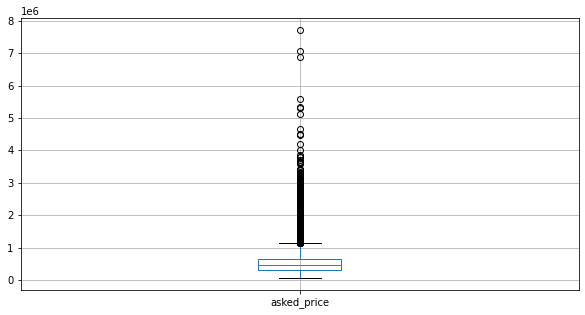

In [13]:
outlier_identifier(df, 'asked_price',c=15)

Price wise, none of these observations can be considered outliers, as these properties with higher prices have features that match their price, such as high number of bathrooms, bedrooms, sqft living area, grade quality (which is the building construction and design level), condition, view, and so on.

##### 3.2.2 Outliers in Bedrooms

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3119,3918400017,2015-02-05,380000.00000,0,0.00000,1470,979,3.00000,0,2,...,8,1470,0,2006,0,98133,47.71450,-122.35600,1470,1399
8484,2310060040,2014-09-25,240000.00000,0,2.50000,1810,5669,2.00000,0,0,...,7,1810,0,2003,0,98038,47.34930,-122.05300,1810,5685
3467,1453602309,2014-08-05,288000.00000,0,1.50000,1430,1650,3.00000,0,0,...,7,1430,0,1999,0,98125,47.72220,-122.29000,1430,1650
4868,6896300380,2014-10-02,228000.00000,0,1.00000,390,5900,1.00000,0,0,...,4,390,0,1953,0,98118,47.52600,-122.26100,2170,6000
18379,1222029077,2014-10-29,265000.00000,0,0.75000,384,213444,1.00000,0,0,...,4,384,0,2003,0,98070,47.41770,-122.49100,1920,224341
9773,3374500520,2015-04-29,355000.00000,0,0.00000,2460,8049,2.00000,0,0,...,8,2460,0,1990,0,98031,47.40950,-122.16800,2520,8050
12653,7849202299,2015-02-18,320000.00000,0,2.50000,1490,7111,2.00000,0,0,...,7,1490,0,1999,0,98065,47.52610,-121.82600,1500,4675
9854,7849202190,2014-12-23,235000.00000,0,0.00000,1470,4800,2.00000,0,0,...,7,1470,0,1996,0,98065,47.52650,-121.82800,1060,7200
6994,2954400190,2014-06-24,1295650.00000,0,0.00000,4810,28008,2.00000,0,0,...,12,4810,0,1990,0,98053,47.66420,-122.06900,4740,35061
14423,9543000205,2015-04-13,139950.00000,0,0.00000,844,4269,1.00000,0,0,...,7,844,0,1913,0,98001,47.27810,-122.25000,1380,9600


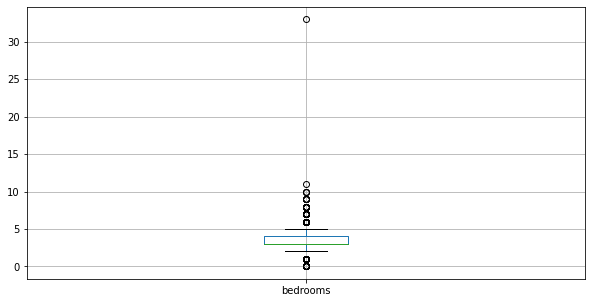

In [14]:
outlier_identifier(df, 'bedrooms', asc=True, c=15)

In [15]:
df.sort_values('bedrooms',ascending=False).head(1)

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.00000,33,1.75000,1620,6000,1.00000,0,0,...,7,1040,580,1947,0,98103,47.68780,-122.33100,1330,4700


This observation is definitely a typo, as a house with 33 bedrooms would probably cost more than $650.000, and would be a lot bigger than 1620 sqft living area. Therefore it will be removed.
The observations that have no bedrooms will also be removed, as those are probably typos.

In [16]:
df = df.loc[(df['bedrooms']!= 33) & (df['bedrooms']!= 0)] # Removing the observation with 33 bedrooms and the ones with 0 bedrooms

##### 3.2.3 Outliers in Bathrooms, Sqft Living, Sqft Lot and Floors

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12777,1225069038,2014-05-05,2280000.00000,7,8.00000,13540,307752,3.00000,0,4,...,12,9410,4130,1999,0,98053,47.66750,-121.98600,4850,217800
7252,6762700020,2014-10-13,7700000.00000,6,8.00000,12050,27600,2.50000,0,3,...,13,8570,3480,1910,1987,98102,47.62980,-122.32300,3940,8800
9254,9208900037,2014-09-19,6885000.00000,6,7.75000,9890,31374,2.00000,0,4,...,13,8860,1030,2001,0,98039,47.63050,-122.24000,4540,42730
8546,424049043,2014-08-11,450000.00000,9,7.50000,4050,6504,2.00000,0,0,...,7,4050,0,1996,0,98144,47.59230,-122.30100,1448,3866
4024,9175600025,2014-10-07,800000.00000,7,6.75000,7480,41664,2.00000,0,2,...,11,5080,2400,1953,0,98166,47.46430,-122.36800,2810,33190
8092,1924059029,2014-06-17,4668000.00000,5,6.75000,9640,13068,1.00000,1,4,...,12,4820,4820,1983,2009,98040,47.55700,-122.21000,3270,10454
20578,424069279,2015-03-28,1180000.00000,6,6.50000,6260,10955,2.00000,0,0,...,11,4840,1420,2007,0,98075,47.59470,-122.03900,2710,12550
21506,2524069097,2014-05-09,2238890.00000,5,6.50000,7270,130017,2.00000,0,0,...,12,6420,850,2010,0,98027,47.53710,-121.98200,1800,44890
14556,2303900035,2014-06-11,2888000.00000,5,6.25000,8670,64033,2.00000,0,4,...,13,6120,2550,1965,2003,98177,47.72950,-122.37200,4140,81021
18302,6072800246,2014-07-02,3300000.00000,5,6.25000,8020,21738,2.00000,0,0,...,11,8020,0,2001,0,98006,47.56750,-122.18900,4160,18969


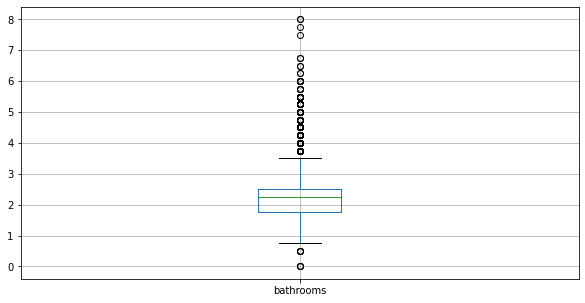

In [17]:
outlier_identifier(df, 'bathrooms', c=10, asc=False)

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12777,1225069038,2014-05-05,2280000.00000,7,8.00000,13540,307752,3.00000,0,4,...,12,9410,4130,1999,0,98053,47.66750,-121.98600,4850,217800
7252,6762700020,2014-10-13,7700000.00000,6,8.00000,12050,27600,2.50000,0,3,...,13,8570,3480,1910,1987,98102,47.62980,-122.32300,3940,8800
3914,9808700762,2014-06-11,7062500.00000,5,4.50000,10040,37325,2.00000,1,2,...,11,7680,2360,1940,2001,98004,47.65000,-122.21400,3930,25449
9254,9208900037,2014-09-19,6885000.00000,6,7.75000,9890,31374,2.00000,0,4,...,13,8860,1030,2001,0,98039,47.63050,-122.24000,4540,42730
8092,1924059029,2014-06-17,4668000.00000,5,6.75000,9640,13068,1.00000,1,4,...,12,4820,4820,1983,2009,98040,47.55700,-122.21000,3270,10454
4411,2470100110,2014-08-04,5570000.00000,5,5.75000,9200,35069,2.00000,0,0,...,13,6200,3000,2001,0,98039,47.62890,-122.23300,3560,24345
14556,2303900035,2014-06-11,2888000.00000,5,6.25000,8670,64033,2.00000,0,4,...,13,6120,2550,1965,2003,98177,47.72950,-122.37200,4140,81021
18302,6072800246,2014-07-02,3300000.00000,5,6.25000,8020,21738,2.00000,0,0,...,11,8020,0,2001,0,98006,47.56750,-122.18900,4160,18969
1164,1247600105,2014-10-20,5110800.00000,5,5.25000,8010,45517,2.00000,1,4,...,12,5990,2020,1999,0,98033,47.67670,-122.21100,3430,26788
1448,8907500070,2015-04-13,5350000.00000,5,5.00000,8000,23985,2.00000,0,4,...,12,6720,1280,2009,0,98004,47.62320,-122.22000,4600,21750


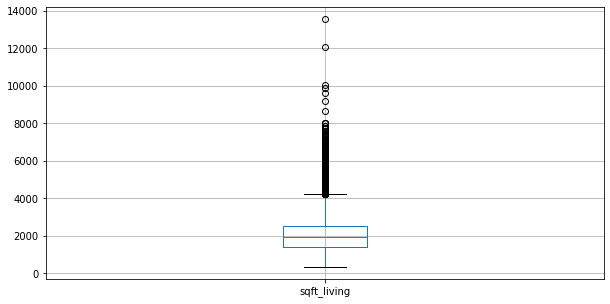

In [18]:
outlier_identifier(df, 'sqft_living', c=10)

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1719,1020069017,2015-03-27,700000.00000,4,1.00000,1300,1651359,1.00000,0,3,...,6,1300,0,1920,0,98022,47.23130,-122.02300,2560,425581
17319,3326079016,2015-05-04,190000.00000,2,1.00000,710,1164794,1.00000,0,0,...,5,710,0,1915,0,98014,47.68880,-121.90900,1680,16730
7647,2623069031,2014-05-21,542500.00000,5,3.25000,3010,1074218,1.50000,0,0,...,8,2010,1000,1931,0,98027,47.45640,-122.00400,2450,68825
7769,2323089009,2015-01-19,855000.00000,4,3.50000,4030,1024068,2.00000,0,0,...,10,4030,0,2006,0,98045,47.46190,-121.74400,1830,11700
3949,722069232,2014-09-05,998000.00000,4,3.25000,3770,982998,2.00000,0,0,...,10,3770,0,1992,0,98058,47.41400,-122.08700,2290,37141
4441,3626079040,2014-07-30,790000.00000,2,3.00000,2560,982278,1.00000,0,0,...,8,2560,0,2004,0,98014,47.69550,-121.86100,1620,40946
6691,2624089007,2015-03-20,1998000.00000,2,2.50000,3900,920423,2.00000,0,0,...,12,3900,0,2009,0,98065,47.53710,-121.75600,2720,411962
7077,2724079090,2015-01-05,1650000.00000,4,3.25000,3920,881654,3.00000,0,3,...,11,3920,0,2002,0,98024,47.53850,-121.89600,2970,112384
20452,1125079111,2015-04-15,1600000.00000,4,5.50000,6530,871200,2.00000,0,2,...,11,6530,0,2008,0,98014,47.66400,-121.87800,1280,858132
9714,225079036,2015-01-07,937500.00000,4,4.00000,5545,871200,2.00000,0,0,...,11,3605,1940,2003,0,98014,47.67600,-121.88200,3420,871200


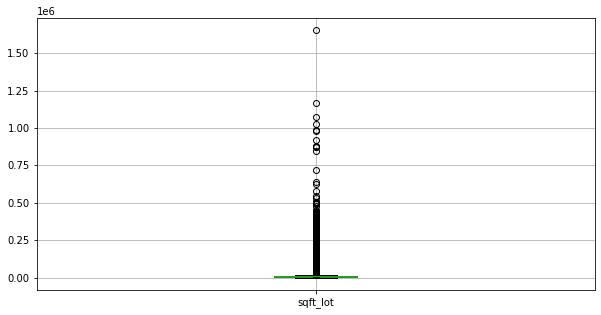

In [19]:
outlier_identifier(df, 'sqft_lot', c=10)

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15424,1702900664,2015-04-16,479000.00000,2,2.50000,1730,1037,3.50000,0,0,...,8,1730,0,2008,0,98118,47.55940,-122.28500,1280,1026
11594,3180100023,2015-01-30,544000.00000,3,2.50000,1760,1755,3.50000,0,0,...,8,1760,0,1998,0,98105,47.66880,-122.27900,1700,1721
20308,1972200426,2014-09-18,525000.00000,2,2.75000,1310,1268,3.50000,0,0,...,8,1310,0,2007,0,98103,47.65340,-122.35500,1350,1288
20772,1972200428,2014-06-25,563500.00000,3,2.50000,1400,1312,3.50000,0,0,...,8,1400,0,2007,0,98103,47.65340,-122.35500,1350,1312
14885,8673400177,2015-04-02,525000.00000,3,3.00000,1730,1074,3.50000,0,0,...,8,1730,0,2006,0,98107,47.66920,-122.39200,1370,1185


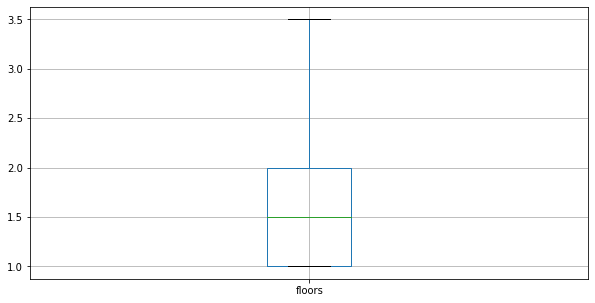

In [20]:
outlier_identifier(df, 'floors')

All these properties with very high sqft living values have reasonable features for such area, for instance the price, grade, number of bathrooms, bedrooms, etc. While for properties with very high sqft lot these seem to be located in rural areas, therefore they don't appear to be outliers. In terms of floors and bathrooms, there's nothing out of the ordinary for this dataset.

### 3.3 Merging the Address Data

Now that the data is cleaned we can merge the dataset with the address data. A few properties will show as NaN in their address, since for those properties this information wasn't available.

In [21]:
df = pd.merge(df, df_address, on='id', how='inner').drop(columns=['query'],axis=1)
df

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number
0,7129300520,2014-10-13,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,0,1955,0,98178,47.51120,-122.25700,1340,5650,61st Avenue South,10012
1,6414100192,2014-12-09,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,400,1951,1991,98125,47.72100,-122.31900,1690,7639,Northeast 127th Street,837
2,5631500400,2015-02-25,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,0,1933,0,98028,47.73790,-122.23300,2720,8062,81st Avenue Northeast,15109
3,2487200875,2014-12-09,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,910,1965,0,98136,47.52080,-122.39300,1360,5000,Fauntleroy Way Southwest,9236
4,1954400510,2015-02-18,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,0,1987,0,98074,47.61680,-122.04500,1800,7503,221st Avenue Northeast,907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,263000018,2014-05-21,360000.00000,3,2.50000,1530,1131,3.00000,0,0,...,0,2009,0,98103,47.69930,-122.34600,1530,1509,North 97th Street,927
21418,6600060120,2015-02-23,400000.00000,4,2.50000,2310,5813,2.00000,0,0,...,0,2014,0,98146,47.51070,-122.36200,1830,7200,Southwest 103rd Place,2211
21419,1523300141,2014-06-23,402101.00000,2,0.75000,1020,1350,2.00000,0,0,...,0,2009,0,98144,47.59440,-122.29900,1020,2007,26th Avenue South,902
21420,291310100,2015-01-16,400000.00000,3,2.50000,1600,2388,2.00000,0,0,...,0,2004,0,98027,47.53450,-122.06900,1410,1287,Northwest Boulder Way Drive,2136


### 3.4 Descriptive Analysis - Cleaned Data

In [22]:
# Descriptive Analysis 
df[['asked_price','bedrooms','bathrooms', 'sqft_living','sqft_lot',
    'floors','waterfront','view','condition','grade','sqft_above',
    'sqft_basement','yr_built','yr_renovated','zipcode','lat','long',
    'sqft_living15','sqft_lot15','road','house_number']].describe().drop(['count']).T

,mean,std,min,25%,50%,75%,max
asked_price,540604.15694,367696.64143,75000.00000,322500.00000,450000.00000,645000.00000,7700000.00000
bedrooms,3.37223,0.90339,1.00000,3.00000,3.00000,4.00000,11.00000
bathrooms,2.11815,0.76909,0.00000,1.75000,2.25000,2.50000,8.00000
sqft_living,2082.95402,918.91596,370.00000,1430.00000,1920.00000,2550.00000,13540.00000
sqft_lot,15130.59920,41529.34601,520.00000,5040.00000,7615.00000,10696.75000,1651359.00000
floors,1.49594,0.54008,1.00000,1.00000,1.50000,2.00000,3.50000
waterfront,0.00761,0.08690,0.00000,0.00000,0.00000,0.00000,1.00000
view,0.23509,0.76713,0.00000,0.00000,0.00000,0.00000,4.00000
condition,3.41065,0.65000,1.00000,3.00000,3.00000,4.00000,5.00000
grade,7.66236,1.17278,3.00000,7.00000,7.00000,8.00000,13.00000


## 4. **Feature Engineering** 

Before we can solve the business problems it's important to create a new feature:
- ad_season: Column that shows on which season the property was announced in the real estate market (spring, summer, fall or winter)

In [23]:
df = df.assign(month_day=df['date'].dt.strftime('%m-%d')) # Getting only the month and day
season_conditions = [(df['month_day']>='03-22') & (df['month_day']<='06-21'), 
                     (df['month_day']>='06-22') & (df['month_day']<='09-23'),
                     (df['month_day']>='09-24') & (df['month_day']<='12-20')]
seasons = ['spring','summer','fall']
df = df.assign(ad_season=np.select(season_conditions, seasons, default='winter')) # Creating a column named ad_season

## 5. **Solving both Business Problems** 

**Problem 1: Which properties should House Rocket buy and for which suggested price?**

In [24]:
df_density_by_zipcode = df[['id','zipcode']].groupby('zipcode').count().reset_index().rename({'id':'properties_in_region'},axis=1) # Getting the density by region
df_density_by_zipcode[['properties_in_region']].describe()

,properties_in_region
count,70.00000
mean,306.02857
std,140.98720
min,49.00000
25%,202.50000
50%,281.50000
75%,403.50000
max,599.00000


In [25]:
df_medians_buy = df[['zipcode', 'asked_price','ad_season']].groupby(['zipcode','ad_season']).median().reset_index().rename({'asked_price': 'median_price_zipcode_season'}, axis=1) # Getting the price median for each zipcode 
df_suggestions = pd.merge(df, df_medians_buy, on=['zipcode','ad_season'], how='inner') # Creating a new DataFrame by adding the median_price column to the original DataFrame
df_suggestions

,id,date,asked_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,road,house_number,month_day,ad_season,median_price_zipcode_season
0,7129300520,2014-10-13,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,98178,47.51120,-122.25700,1340,5650,61st Avenue South,10012,10-13,fall,284000.00000
1,2976800796,2014-09-25,236000.00000,3,1.00000,1300,5898,1.00000,0,0,...,98178,47.50530,-122.25500,1320,7619,63rd Avenue South,10658,09-25,fall,284000.00000
2,3352402236,2014-12-15,252500.00000,3,2.00000,1150,6000,1.00000,0,0,...,98178,47.49800,-122.26300,1980,6360,Beacon Avenue South,11708,12-15,fall,284000.00000
3,1180002378,2014-09-26,299000.00000,4,2.50000,1950,3000,2.00000,0,0,...,98178,47.49770,-122.22600,1170,6000,South 117th Place,8438,09-26,fall,284000.00000
4,1180500070,2014-11-24,335000.00000,4,2.50000,2330,7050,2.00000,0,0,...,98178,47.50010,-122.23100,1810,5424,81st Place South,11431,11-24,fall,284000.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,3262300485,2015-04-21,2250000.00000,5,5.25000,3410,8118,2.00000,0,0,...,98039,47.62950,-122.23600,3410,16236,78th Avenue Northeast,2091,04-21,spring,1800000.00000
21418,9558200210,2015-02-17,290000.00000,3,1.00000,1240,9300,1.00000,0,0,...,98148,47.43630,-122.33300,1250,9300,South 186th Street,205,02-17,winter,282750.00000
21419,854000165,2015-01-07,285000.00000,3,1.50000,1400,7582,1.00000,0,0,...,98148,47.45360,-122.33000,1280,7872,3rd Avenue South,16711,01-07,winter,282750.00000
21420,5245400030,2015-02-23,255000.00000,4,1.00000,1250,9102,1.00000,0,0,...,98148,47.42580,-122.32700,1260,9180,South 198th Street,620,02-23,winter,282750.00000


Now it's necessary to determine the buy suggestions based on conditions:
- Their asked price has to be lower than the median price for that region
- The property needs to be in good conditions, which means condition >= 3

In [26]:
buy_condition = [((df_suggestions['asked_price'] < df_suggestions['median_price_zipcode_season']) & (df_suggestions['condition']>=3))] # Conditions
df_suggestions['buy_suggestion'] = np.select(buy_condition, ['Yes'], default='No') # Using np.select to create the buy suggestion column
df_buy = pd.merge(df_suggestions, df_density_by_zipcode, on='zipcode', how='inner')[['id','date','ad_season','zipcode','properties_in_region','lat','long','median_price_zipcode_season','asked_price','condition','buy_suggestion']].rename({'price':'asked_price'},axis=1)
df_buy

,id,date,ad_season,zipcode,properties_in_region,lat,long,median_price_zipcode_season,asked_price,condition,buy_suggestion
0,7129300520,2014-10-13,fall,98178,258,47.51120,-122.25700,284000.00000,221900.00000,3,Yes
1,2976800796,2014-09-25,fall,98178,258,47.50530,-122.25500,284000.00000,236000.00000,3,Yes
2,3352402236,2014-12-15,fall,98178,258,47.49800,-122.26300,284000.00000,252500.00000,5,Yes
3,1180002378,2014-09-26,fall,98178,258,47.49770,-122.22600,284000.00000,299000.00000,3,No
4,1180500070,2014-11-24,fall,98178,258,47.50010,-122.23100,284000.00000,335000.00000,3,No
...,...,...,...,...,...,...,...,...,...,...,...
21417,7397300170,2014-05-30,spring,98039,49,47.63950,-122.23400,1800000.00000,3710000.00000,4,No
21418,3262300920,2015-04-08,spring,98039,49,47.63350,-122.23600,1800000.00000,1200000.00000,3,Yes
21419,2470200020,2014-05-14,spring,98039,49,47.62450,-122.23600,1800000.00000,1880000.00000,4,No
21420,2425049066,2014-06-16,spring,98039,49,47.64000,-122.24000,1800000.00000,1920000.00000,4,No


After the suggested properties to be bought are determined, the suggested price for each one of them needs to be set, based on the density by region. The rule for suggested buy prices is:

- From 0 to 204 properties in the region => Offer the asked price 
- From 205 to 282 properties in the region => Offer 3% less than the asked price
- From 283 to 408 properties in the region => Offer 4% less than the asked price
- From 409 properties upwards => Offer 5% less than the asked price

In [27]:
setting_buy_price_suggestion(df_buy)

,id,date,ad_season,zipcode,properties_in_region,lat,long,median_price_zipcode_season,asked_price,condition,buy_suggestion,suggested_buy_price
0,7129300520,2014-10-13,fall,98178,258,47.51120,-122.25700,284000.00000,221900.00000,3,Yes,215243.0
1,2976800796,2014-09-25,fall,98178,258,47.50530,-122.25500,284000.00000,236000.00000,3,Yes,228920.0
2,3352402236,2014-12-15,fall,98178,258,47.49800,-122.26300,284000.00000,252500.00000,5,Yes,244925.0
3,1180002378,2014-09-26,fall,98178,258,47.49770,-122.22600,284000.00000,299000.00000,3,No,Not suggested
4,1180500070,2014-11-24,fall,98178,258,47.50010,-122.23100,284000.00000,335000.00000,3,No,Not suggested
...,...,...,...,...,...,...,...,...,...,...,...,...
21417,7397300170,2014-05-30,spring,98039,49,47.63950,-122.23400,1800000.00000,3710000.00000,4,No,Not suggested
21418,3262300920,2015-04-08,spring,98039,49,47.63350,-122.23600,1800000.00000,1200000.00000,3,Yes,1200000.0
21419,2470200020,2014-05-14,spring,98039,49,47.62450,-122.23600,1800000.00000,1880000.00000,4,No,Not suggested
21420,2425049066,2014-06-16,spring,98039,49,47.64000,-122.24000,1800000.00000,1920000.00000,4,No,Not suggested


In [29]:
df_buy_final = df_buy[['id','date','zipcode','median_price_zipcode_season','asked_price','buy_suggestion','suggested_buy_price']]
df_buy_final = pd.merge(df_buy_final, df_address, on='id', how='inner').drop(columns=['query'],axis=1)
df_buy_final # Final data set with buy suggestions and suggested buy prices

,id,date,zipcode,median_price_zipcode_season,asked_price,buy_suggestion,suggested_buy_price,road,house_number
0,7129300520,2014-10-13,98178,284000.00000,221900.00000,Yes,215243.0,61st Avenue South,10012
1,2976800796,2014-09-25,98178,284000.00000,236000.00000,Yes,228920.0,63rd Avenue South,10658
2,3352402236,2014-12-15,98178,284000.00000,252500.00000,Yes,244925.0,Beacon Avenue South,11708
3,1180002378,2014-09-26,98178,284000.00000,299000.00000,No,Not suggested,South 117th Place,8438
4,1180500070,2014-11-24,98178,284000.00000,335000.00000,No,Not suggested,81st Place South,11431
...,...,...,...,...,...,...,...,...,...
21417,7397300170,2014-05-30,98039,1800000.00000,3710000.00000,No,Not suggested,80th Avenue Northeast,NaN
21418,3262300920,2015-04-08,98039,1800000.00000,1200000.00000,Yes,1200000.0,78th Avenue Northeast,2511
21419,2470200020,2014-05-14,98039,1800000.00000,1880000.00000,No,Not suggested,Northeast 16th Street,7775
21420,2425049066,2014-06-16,98039,1800000.00000,1920000.00000,No,Not suggested,Evergreen Point Road,NaN


**Problem 2: Once a property is bought, for which price should it be sold?**

The rule for suggesting a sell price for those properties is:
- From 0 to 204 properties in the region => Sell for 16% than the suggested buy price 
- From 205 to 282 properties in the region => Sell for 14% than the suggested buy price
- From 283 to 408 properties in the region => Sell for 12% than the suggested buy price
- From 409 properties upwards => Sell for 10% than the suggested buy price

In [30]:
df_sell = df_buy[['id','date','ad_season','zipcode','properties_in_region','lat','long','asked_price','buy_suggestion','suggested_buy_price']] # Setting the sell DataFrame1
df_sell = df_sell.loc[df_sell['buy_suggestion']=='Yes'].drop(columns=['buy_suggestion', 'asked_price'],axis=1) # Getting only the properties that were suggested to be bought
df_sell['suggested_buy_price'] = pd.to_numeric(df_sell['suggested_buy_price']) # Converting suggested_buy_price to float

In [31]:
setting_sell_price_suggestion(df_sell)

,id,date,ad_season,zipcode,properties_in_region,lat,long,suggested_buy_price,suggested_sell_price,profit
0,7129300520,2014-10-13,fall,98178,258,47.51120,-122.25700,215243.00000,245377.02000,30134.02000
1,2976800796,2014-09-25,fall,98178,258,47.50530,-122.25500,228920.00000,260968.80000,32048.80000
2,3352402236,2014-12-15,fall,98178,258,47.49800,-122.26300,244925.00000,279214.50000,34289.50000
5,179000350,2014-11-05,fall,98178,258,47.49250,-122.27800,188180.00000,214525.20000,26345.20000
8,179003055,2014-11-13,fall,98178,258,47.49210,-122.27500,203700.00000,232218.00000,28518.00000
...,...,...,...,...,...,...,...,...,...,...
21409,2525049133,2015-04-02,spring,98039,49,47.61910,-122.23400,1398000.00000,1621680.00000,223680.00000
21412,3262300322,2015-04-08,spring,98039,49,47.62930,-122.23800,1651000.00000,1915160.00000,264160.00000
21414,5427110040,2014-06-09,spring,98039,49,47.63530,-122.22900,1225000.00000,1421000.00000,196000.00000
21416,3025300250,2015-05-13,spring,98039,49,47.62320,-122.23600,1620000.00000,1879200.00000,259200.00000


In [32]:
df_sell = df_sell[['id','ad_season','zipcode','lat','long','suggested_buy_price','suggested_sell_price','profit']]
df_sell_final = df_sell[['id','ad_season','zipcode','suggested_buy_price','suggested_sell_price','profit']]
df_sell_final = pd.merge(df_sell_final, df_address, on='id', how='inner').drop(columns=['query'],axis=1)
df_sell_final  # Final data set with suggested sell prices and profit

,id,ad_season,zipcode,suggested_buy_price,suggested_sell_price,profit,road,house_number
0,7129300520,fall,98178,215243.00000,245377.02000,30134.02000,61st Avenue South,10012
1,2976800796,fall,98178,228920.00000,260968.80000,32048.80000,63rd Avenue South,10658
2,3352402236,fall,98178,244925.00000,279214.50000,34289.50000,Beacon Avenue South,11708
3,179000350,fall,98178,188180.00000,214525.20000,26345.20000,44th Avenue South,12253
4,179003055,fall,98178,203700.00000,232218.00000,28518.00000,South 124th Street,4623
...,...,...,...,...,...,...,...,...
10430,2525049133,spring,98039,1398000.00000,1621680.00000,223680.00000,Northeast 10th Street,7903
10431,3262300322,spring,98039,1651000.00000,1915160.00000,264160.00000,77th Avenue Northeast,2027
10432,5427110040,spring,98039,1225000.00000,1421000.00000,196000.00000,Northeast 28th Street,NaN
10433,3025300250,spring,98039,1620000.00000,1879200.00000,259200.00000,Northeast 14th Street,7744


## 6. **Financial Results**

Three interesting metrics to evaluate the financial performance for this solution is the profit mean and median (grouped by ad_season, zipcode and ad_season with zipcode), as well as the total profit. 

In [33]:
df1 = df_sell[['profit']].describe().drop(['count'])
median_profit = pd.DataFrame(df_sell[['profit']].apply(np.median)).rename(columns={0:'median'}).transpose() # Adding the median
total_profit = pd.DataFrame(df_sell[['profit']].apply(np.sum)).rename(columns={0:'total'}).transpose() # Adding the sum
df_profit = pd.concat([df1, median_profit, total_profit]).reindex(['total','mean','median','std','min','25%','50%','75%','max'])

df_profit

,profit
total,473094328.48000
mean,45337.26195
median,39995.00000
std,22772.81950
min,8217.50000
25%,30210.00000
50%,39995.00000
75%,54144.00000
max,350036.80000


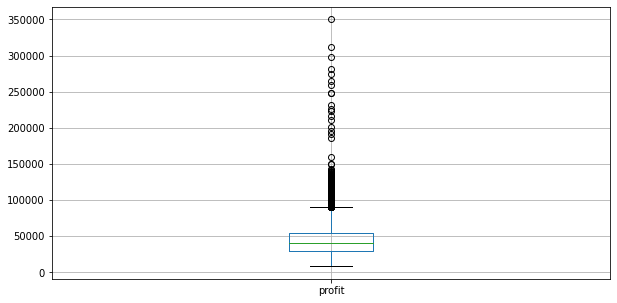

In [34]:
df_sell[['profit']].boxplot(figsize=(10,5));

In [35]:
med_avg_profit_by_season = avg_profit_func(df_sell,['ad_season','profit'], 'ad_season')    
med_avg_profit_by_season # Average and median profit by ad_season

,ad_season,avg_profit,median_profit
0,fall,44130.53530,38475.00000
1,spring,46985.94344,41538.75000
2,summer,45211.13089,40375.00000
3,winter,44085.70760,38000.00000


In [36]:
med_avg_profit_by_zipcode = avg_profit_func(df_sell,['zipcode','profit','lat','long'], 'zipcode')    
med_avg_profit_by_zipcode = med_avg_profit_by_zipcode[['zipcode','lat','long','avg_profit','median_profit']]
med_avg_profit_by_zipcode # Average and median profit by zipcode

,zipcode,lat,long,avg_profit,median_profit
0,98001,47.30207,-122.26829,24334.99432,24768.00000
1,98002,47.30402,-122.21578,30863.81224,31756.00000
2,98003,47.31872,-122.31096,30262.66820,30616.11000
3,98004,47.61274,-122.20072,97809.52985,97257.60000
4,98005,47.60147,-122.16810,100777.83901,101600.00000
...,...,...,...,...,...
65,98177,47.74495,-122.36565,57869.29143,57850.80000
66,98178,47.49737,-122.25069,29500.48929,30351.30000
67,98188,47.44769,-122.28250,34510.77091,36000.00000
68,98198,47.39384,-122.31342,28484.95196,28687.75000


In [37]:
med_avg_profit_by_zipcode_season = avg_profit_func(df_sell,['zipcode','ad_season','profit'], ['zipcode','ad_season'])    
med_avg_profit_by_zipcode_season # Average and median profit by ad_season and zipcode

,zipcode,ad_season,avg_profit,median_profit
0,98001,fall,23510.84012,24192.00000
1,98001,spring,24139.57045,24768.00000
2,98001,summer,24648.50824,25228.80000
3,98001,winter,25126.49193,26092.80000
4,98002,fall,30588.63333,30800.00000
...,...,...,...,...
275,98198,winter,28661.92375,27903.50500
276,98199,fall,56809.97053,58792.32000
277,98199,spring,63535.24357,64961.28000
278,98199,summer,63336.10423,61632.00000


## 7. **Hypotheses, Business Insights and Exploratory Data Analysis**

All these hypothesis have the potential to become a business insight. An insight is a discovery that can be turned into a useful doable action, which means those have an **Usage**. 

##### **H1** - Properties that possess waterfront view are, on average, considerably more expensive in comparison to the ones that do not have such feature

In [40]:
no_waterfront_avg_price = df['asked_price'][df['waterfront']==0].mean()
waterfront_avg_price = df['asked_price'][df['waterfront']==1].mean()

price_comparison = ((waterfront_avg_price/no_waterfront_avg_price) - 1)*100

print(f'True: Properties that possess waterfront view are, on average, {round(price_comparison,2)}% more expensive in comparison to the ones that do not have such feature.')

True: Properties that possess waterfront view are, on average, 212.38% more expensive in comparison to the ones that do not have such feature.


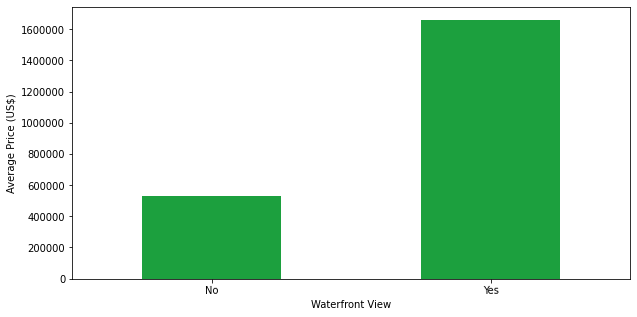

In [41]:
df_water = df[['asked_price', 'waterfront']].groupby('waterfront').mean().reset_index()
df_water['waterfront'] = df_water['waterfront'].apply(lambda x: "No" if x==0 else "Yes")

bar_plot(df_water,'waterfront','Waterfront View','asked_price','Average Price (US$)')

**INSIGHT**

**Usage**: House Rocket could focus on buying and selling waterfront view properties, since the profit will be higher in absolut values.  

##### H2 - A property year built is directly proportional to its price, on average.

False: Properties with the lowest prices (on average) were built from 1941 to 1983. This means that houses built from 1900-1940 have higher prices than the ones built from 1941-1983


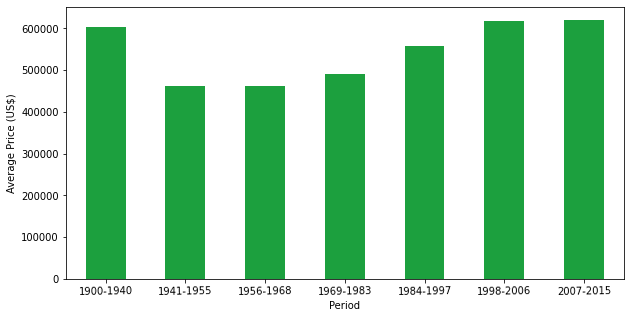

In [42]:
df_yrbuilt = period(df)
bar_plot(df_yrbuilt,'Period','Period','asked_price','Average Price (US$)')
# plt.savefig('images/periods.pdf', bbox_inches='tight') 
print(f'False: Properties with the lowest prices (on average) were built from 1941 to 1983. This means that houses built from 1900-1940 have higher prices than the ones built from 1941-1983')

**INSIGHT**

**Usage**: House Rocket would have higher profits buying and selling properties built from the mid 1980's upwards, as well as the ones built from 1900 to 1940.

##### H3 - Properties that do not have a basement are, on average, around 30% cheaper in comparison to the ones that have such feature.

In [43]:
price_no_basement = df.loc[df['sqft_basement']==0, 'asked_price'].mean()
price_basement = df.loc[df['sqft_basement']!=0, 'asked_price'].mean()
sqft_comparison = ((price_basement/price_no_basement) - 1)*100
print(f'True: Properties that do not have a basement are, on average, {round(sqft_comparison,2)}% cheaper in comparison to the ones that have such feature.')

True: Properties that do not have a basement are, on average, 27.71% cheaper in comparison to the ones that have such feature.


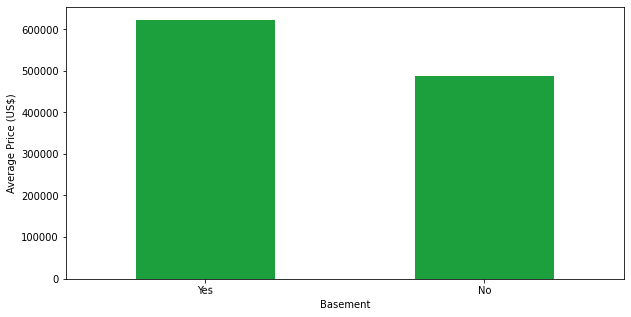

In [44]:
df_basement = pd.DataFrame({'asked_price':[price_basement,price_no_basement]}, index=['Yes','No']).reset_index().rename({'index':'basement'},axis=1)
bar_plot(df_basement,'basement', 'Basement','asked_price','Average Price (US$)')

**INSIGHT**

**Usage**: House Rocket could look to buy properties without a basement that have the potential to possess one. Therefore these properties can be sold for a lot higher price. 

##### H4 - The average price growth YoY considering all properties in the dataset is 5%

In [45]:
df_price = df[['asked_price','yr_built']].groupby('yr_built').mean().reset_index()
df_price['year_growth'] = (df_price['asked_price'].pct_change())*100
df_avg_price = df_price['year_growth'].mean()

print(f'False: The average price growth YoY considering all properties in the dataset is {round(df_avg_price,2)}%.')

False: The average price growth YoY considering all properties in the dataset is 1.09%.


##### H5 - The average price growth MoM (month over month) for properties with three bathrooms is 1%

In this case, we can also consider a property with three bathrooms the ones in which this value is equal to 2.5 or 2.75, as .5 represents a room with a toilet but no shower or bath, and .75 represents a room with a toilet and shower or bath, not both. 

In [46]:
df_3_bathrooms = df[['id','date','asked_price','bathrooms']].loc[(df['bathrooms']>=2.5) & (df['bathrooms']<=3.00)]
df_3_bathrooms['month'] = df_3_bathrooms['date'].dt.strftime('%Y-%m')
df_3_bathrooms = df_3_bathrooms[['asked_price','month']].groupby('month').mean().reset_index()

df_3_bathrooms['month_growth'] = (df_3_bathrooms['asked_price'].pct_change())*100
df_3_bathrooms_avg_price = df_3_bathrooms['month_growth'].mean()

print(f'False: The average price growth MoM for properties with three bathrooms is {round(df_3_bathrooms_avg_price,3)}%.')

False: The average price growth MoM for properties with three bathrooms is -0.609%.


##### H6 - Properties with good views are, on average, around two times more expensive than the ones with not so good views

In [47]:
df_bad_view = df.loc[df['view']==0, 'asked_price'].mean()
df_good_view = df.loc[df['view']!=0, 'asked_price'].mean()

view_comparison = df_good_view/df_bad_view

print(f'True: Properties with good views are, on average, {round(view_comparison,2)} times more expensive than the ones with not so good views')

True: Properties with good views are, on average, 1.89 times more expensive than the ones with not so good views


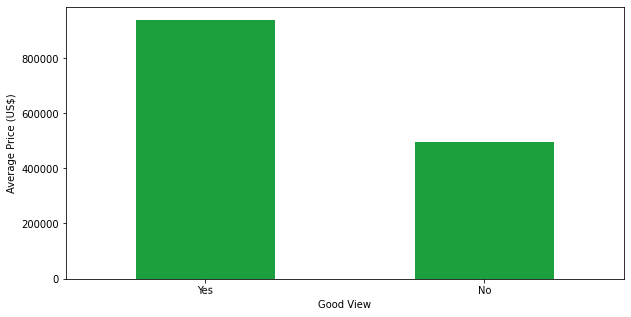

In [48]:
df_view = pd.DataFrame({'asked_price':[df_good_view,df_bad_view]}, index=['Yes','No']).reset_index().rename({'index':'good_view'},axis=1)
bar_plot(df_view,'good_view', 'Good View','asked_price','Average Price (US$)')

**INSIGHT**

**Usage**: House Rocket could focus on buying and selling properties with good views, since the profit will be higher in absolut values.

##### H7 - If a property has a waterfront view those necessarily have a good view

In [49]:
water_and_good_view = len(df.loc[(df['view']!=0)&(df['waterfront']==1)]) # all properties with waterfront view and good views
water_view = len(df.loc[(df['waterfront']==1)]) # all properties with waterfront view

water_view_comparison = (water_and_good_view/water_view)*100

print(f'True: {round(water_view_comparison,2)}% of properties with waterfront view also have a good view, necessarily.')

True: 100.0% of properties with waterfront view also have a good view, necessarily.


##### H8 - Properties that were renovated are, on average, in better conditions in comparison to the ones that weren't.

In [50]:
not_renovated = df.loc[(df['yr_renovated']==0), 'condition'].mean()
renovated = df.loc[(df['yr_renovated']!=0), 'condition'].mean()
dict_renovated = {'renovated':renovated, 'not renovated':not_renovated}

print(f'False: The properties that have better conditions are, on average, the {max(dict_renovated, key=dict_renovated.get)} ones.')

False: The properties that have better conditions are, on average, the not renovated ones.


##### H9 - Regions bordering Lake Washington produce, on average, considerably more profit in comparison to other regions.

In [51]:
zipcodes_lake = [98178,98118,98144,98112,98122,98105,98115,98125,98155,98028,98034,98033,98004,98039,98040,98006,98056]
avg_profit_lake = med_avg_profit_by_zipcode.loc[med_avg_profit_by_zipcode['zipcode'].isin(zipcodes_lake), 'avg_profit'].mean()
avg_profit_not_lake = med_avg_profit_by_zipcode.loc[~med_avg_profit_by_zipcode['zipcode'].isin(zipcodes_lake), 'avg_profit'].mean()
comparison_lake = ((avg_profit_lake/avg_profit_not_lake) - 1)*100
print(f'True: Regions bordering Lake Washington produce, on average, {round(comparison_lake,2)}% more profit in comparison to other regions.')

True: Regions bordering Lake Washington produce, on average, 36.23% more profit in comparison to other regions.


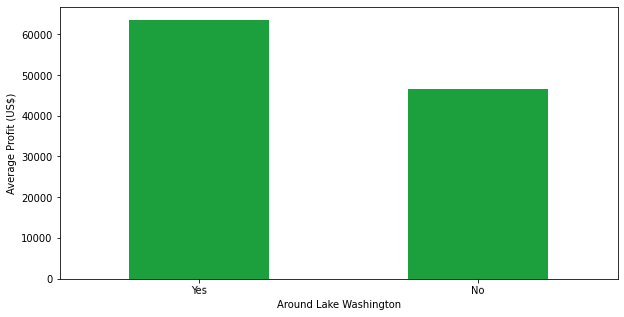

In [52]:
df_lake = pd.DataFrame({'avg_profit':[avg_profit_lake,avg_profit_not_lake]}, index=['Yes','No']).reset_index().rename({'index':'around_lake'},axis=1)
bar_plot(df_lake,'around_lake', 'Around Lake Washington','avg_profit','Average Profit (US$)')

**INSIGHT**

**Usage**: House Rocket could focus on buying and selling properties around Lake Washington, since the profit will be higher in absolut values.

## 8. **Conclusion**

In this project the two main objectives were accomplished:

 - A feasible solution was found for both business problems, leading to profitable results.
 - Five interesting and useful insights were found through Exploratory Data Analysis (EDA).

 We also managed to deliver tables with in-depth financial results, as well as buy and sell suggestion tables. All this information can be filtered by using the [House Rocket Cloud App](https://brunodifranco-house-rocket-app-house-rocket-app-4dn0re.streamlitapp.com/), that also has the five business insights and a interactive Buy Suggestion Map.   

## 9. **Next Steps**

Further on, this solution could be improved by using [regression models](https://www.imsl.com/blog/what-is-regression-model) to determine wheter a property is in a good buying price, and for which price it could be bought and sold. Another interesting study would be to produce a market research, so that data about clients could be collected. Then, a [clustering algorithm](https://machinelearningmastery.com/clustering-algorithms-with-python/) could be applied to identify what types of property features each group of customers would prefer. 